# 0. Importing packages

In [18]:
from scipy.optimize import differential_evolution
import numpy as np
from matplotlib import pyplot as plt

from packages.functions import calcL1MET
import optimisation_2024 as opt

# 1. Loading data

In [2]:
data2024 = "/shared/scratch/wq22321/data/NANOAOD_Muon0Run2023D_ZMu_PromptReco_v2RAW_RECO_2023_v0_4/231121_100830/0000/out_10.root"

In [3]:
fit, valid = opt.prepareInputs(dir = data2024, subset=0.7, cuts=(0, 250))

Reading in calo tower data
Reading in PUPPI MET pT and phi
Calculating x and y components of PUPPI MET
Reading in muon pT and phi
Calculating muon ptx and pty for each event
Calculating PUPPI MET no Mu and reformatting data


/users/wq22321/methackathon_2024/packages/functions.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfcand_muons['muon_ptx'] = np.cos(pfcand_muons['Muon_phi']) * pfcand_muons['Muon_pt']
/users/wq22321/methackathon_2024/packages/functions.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfcand_muons['muon_pty'] = np.sin(pfcand_muons['Muon_phi']) * pfcand_muons['Muon_pt']


Subsetting events
Calculating NTT4


# 2. Optimisation

In [5]:
print("Starting optimisation")

bounds = [(0, 3), (0, 4), (0, 3), (0, 4)]
x0 = (2.0, 2.0, 0.5, 2.0)
turn_on_options = (True, 80, 0.05)
result = differential_evolution(
    func     = opt.objective,
    bounds   = bounds,
    args     = (fit, turn_on_options),
    
    x0 = x0,
    popsize  = 15,    # 15
    maxiter  = 10,    # 1000
    strategy = "best1bin",    # "best1bin"
    init     = "sobol",    #"latinhypercube"
    disp     = True,
    workers  = -1,    # 1
    polish   = False
    )

print(result.x)
print(result)

Starting optimisation


/users/wq22321/methackathon_2024/.venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,



Currently trying: a = 2.0, b = 2.0, c = 0.5 and d = 2.0

Currently trying: a = 2.91, b = 1.15, c = 2.88 and d = 1.42

Currently trying: a = 2.01, b = 2.19, c = 0.74 and d = 3.22

Currently trying: a = 0.1, b = 0.51, c = 1.94 and d = 0.54

Currently trying: a = 0.5, b = 2.73, c = 2.33 and d = 0.49

Currently trying: a = 1.59, b = 0.03, c = 1.08 and d = 3.81

Currently trying: a = 2.57, b = 3.12, c = 1.76 and d = 1.61

Currently trying: a = 1.41, b = 1.68, c = 0.14 and d = 2.16

Currently trying: a = 1.25, b = 2.43, c = 1.6 and d = 3.68

Currently trying: a = 2.36, b = 0.87, c = 0.22 and d = 0.12

Currently trying: a = 1.81, b = 3.79, c = 2.54 and d = 2.29

Currently trying: a = 0.68, b = 1.48, c = 0.77 and d = 1.98
Turn on width: 111.61

Currently trying: a = 0.31, b = 3.26, c = 0.39 and d = 1.05
Turn on width: 104.11

Currently trying: a = 2.18, b = 1.94, c = 2.2 and d = 2.74
Turn on width: 113.1

Currently trying: a = 2.75, b = 2.9, c = 1.32 and d = 0.91
Turn on width: 104.11
Turn on

Process ForkPoolWorker-35:
Process ForkPoolWorker-32:
Process ForkPoolWorker-16:
Process ForkPoolWorker-37:
Process ForkPoolWorker-14:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-33:
Process ForkPoolWorker-29:
Process ForkPoolWorker-4:
Process ForkPoolWorker-26:
Process ForkPoolWorker-13:
Process ForkPoolWorker-24:
Process ForkPoolWorker-9:
Process ForkPoolWorker-30:
Process ForkPoolWorker-3:
Process ForkPoolWorker-18:
Process ForkPoolWorker-12:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-17:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-10:
Process ForkPoolWorker-27:
Process ForkPoolWorker-20:
Process ForkPoolWorker-6:
Process ForkPoolWorker-34:
Process ForkPoolWorker-36:
Process ForkPoolWorker-25:
Process ForkPoolWorker-11:
Process ForkPoolWorker-31:
Process ForkPoolWorker-5:
Process ForkPoolWorker-28:
Process ForkPoolWorker-15:
Process Fo

Turn on width: 104.11

Process ForkPoolWorker-39:


Traceback (most recent call last):
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/users/wq22321/methackathon_2024/.venv/lib/python3.9/site-packages/scipy/_lib/_util.py", line 426, in __call__
    return self.f(x, *self.args)
  File "/users/wq22321/methackathon_2024/optimisation_2024.py", line 80, in objective
    MET, _ = applyCaloTowerThresh(calo, a, b, c, d)
  File "/users/wq22321/methackathon_2024/optimisation_2024.py", line 72, in applyCaloTowerThresh
    return calcL1MET(MET), MET.astype(int)
  File "/users

Process ForkPoolWorker-38:
Traceback (most recent call last):
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

In [7]:
result.x

array([0.4785183 , 2.95870881, 0.19865517, 1.69915227])

# 3. Parameter analysis

In [10]:
def heatmapper(a, b, c, d):
    dat = lookup_gen(a, b, c, d)
    ietas, pu_bins, thresh = zip(*dat)
    plt.figure(figsize=(15,9))
    plt.hist2d(ietas, pu_bins, weights=thresh, bins=[83, 32])
    plt.colorbar()
    #plt.xlim([1,41]); plt.ylim([0,31])
    plt.xlabel("ieta"); plt.ylabel("NTT4 bin")
    plt.title("2D histogram of tower threshold (scaled by tower size)")
    plt.show()

In [11]:
def lookup_gen(a, b, c, d):
    
    all_ieta_vals = np.linspace(-41, 41, 83)
    all_pu_bins = np.linspace(0, 31, 32)
    
    res = []
    for ieta in all_ieta_vals:
        for pu_bin in all_pu_bins:
            thresh = threshold_calc(ieta, pu_bin, a, b, c, d)
            res.append((ieta, pu_bin, thresh))
            
    return res

In [12]:
def threshold_calc(ieta, ntt4, a, b, c, d):
    towerAreas = [    0., # dummy for ieta=0
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.03,1.15,1.3,1.48,1.72,2.05,1.72,4.02,
                  0., # dummy for ieta=29
                  3.29,2.01,2.02,2.01,2.02,2.0,2.03,1.99,2.02,2.04,2.00,3.47]
    
    numerator = (towerAreas[int(abs(ieta))]**a) * (ntt4**c)
    denominator = d * (1 + np.exp(-b * (abs(ieta))))
    
    threshold = (numerator / denominator).clip(max=40)
#    return (threshold/2)# / towerAreas[int(abs(ieta))]
    if towerAreas[int(abs(ieta))] == 0:
        return np.nan
    else:
        return (threshold/2)# / towerAreas[int(abs(ieta))]

In [13]:
fw = (0.66881105, 1.77791976, 0.96226907, 2.08912586)
reg = (0.21456065, 2.74961211, 0.47896413, 0.30650943)
old = (1.707, 3.078, 0.195, 1.365)

quick = (2.49418849, 3.06860578, 0.22999811, 3.75036927)
quick2 = (0.4785183 , 2.95870881, 0.19865517, 1.69915227)

zmu23_1 = (1.87, 1.34, 0.1, 2.84)
zmu23_2 = (1.49, 2.91, 0.26, 1.51)
zmu23_3 = (2.34, 2.82, 0.37, 2.79)

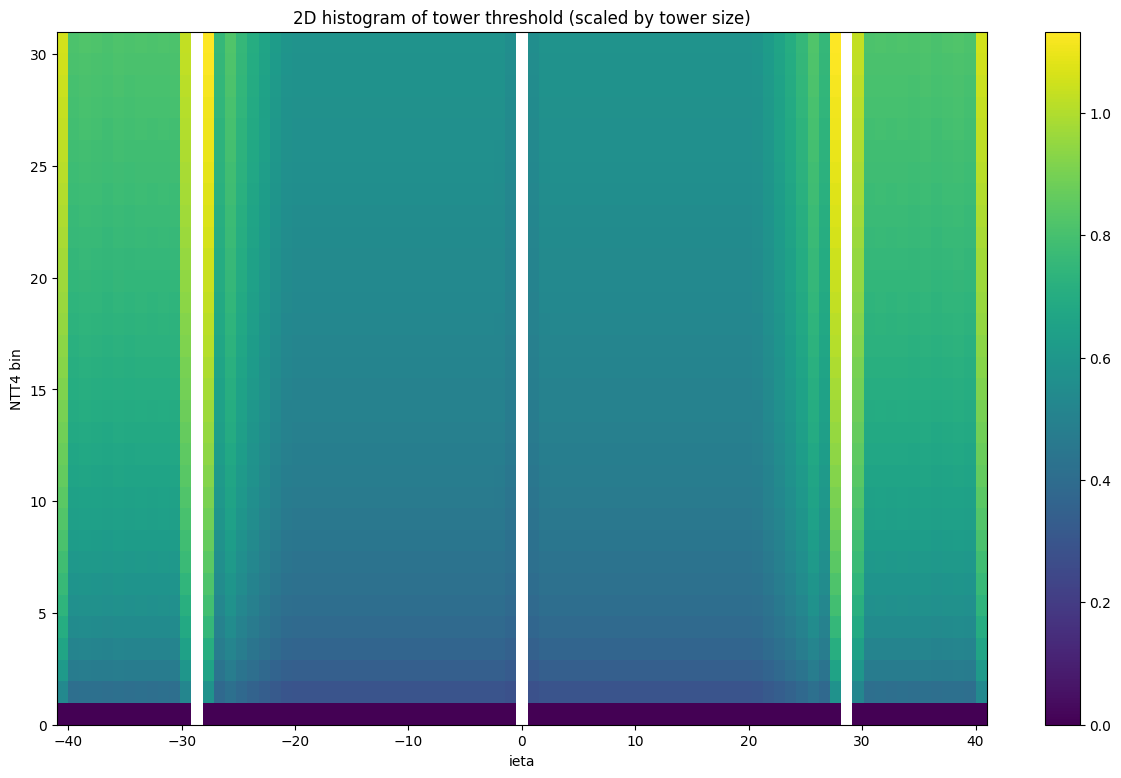

In [14]:
heatmapper(*quick2)

In [15]:
valid_calo, valid_puppi, valid_ntt4 = valid

In [16]:
MET = opt.applyCaloTowerThresh(valid_calo, *quick2)[0]

In [19]:
l1met = calcL1MET(valid_calo)

In [20]:
def getTurnOn( online, offline, threshold=80 ) :
    offline_bins = np.linspace(0, 300, 40)
    efficiency = []


    for i in range(len(offline_bins) - 1):
        # Define the offline range for this bin
        offline_range = (offline >= offline_bins[i]) & (offline < offline_bins[i + 1])
        # count the number of events passing the threshold in the offline range
        num_offline = sum(offline_range)
        # count the number of events passing the threshold in both online and offline ranges
        num_both = sum((online > threshold) & offline_range)
        # calculate the efficiency as the ratio of online events passing the cut over offline events passing the threshold
        if num_offline > 0:
            eff = num_both / num_offline
        else:
            eff = 0
        efficiency.append(eff)

    bin_centers = (offline_bins[:-1] + offline_bins[1:]) / 2

    return bin_centers, efficiency

In [21]:
bins, turnon = getTurnOn(MET, valid_puppi)

In [22]:
_, turnon_noPU = getTurnOn(l1met, valid_puppi)

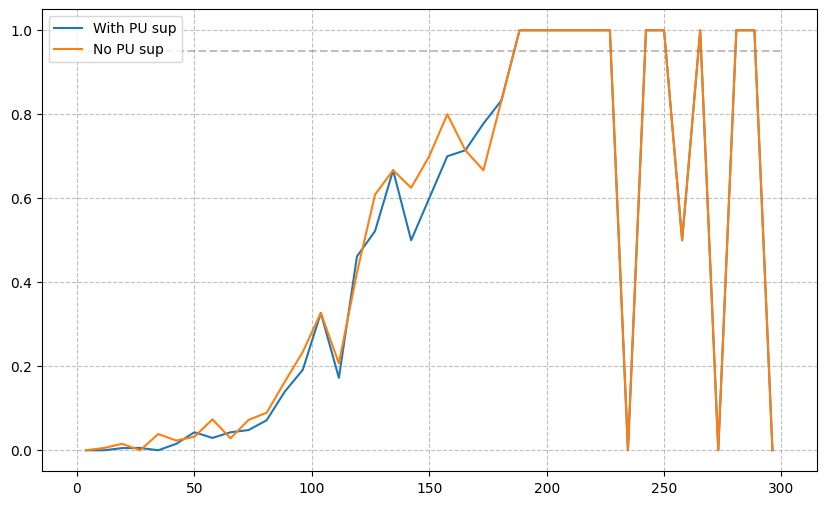

In [23]:
plt.figure(figsize=(10,6))

plt.plot(bins, turnon, label="With PU sup")
plt.plot(_, turnon_noPU, label = "No PU sup")

plt.grid(True, linestyle='--', color='gray', alpha=0.5)
plt.hlines(0.95, xmin=0, xmax=300, colors='gray', linestyles='--', alpha=0.5)
plt.legend()
plt.show()